## Libraries

In [4]:
from openvino.runtime import Core
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd

from time import time
import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Try model in OpenVino

In [3]:
ie = Core()
# path to xml file with model converted to OpenVino's IR format. bin file should be in the same directory
model = ie.read_model(model=os.path.normpath(r"models\enet_b0_8\FP16\enet_b0_8_FP16.xml"))
compiled_model = ie.compile_model(model=model, device_name="CPU")

output_layer = next(iter(compiled_model.outputs))
input_layer = next(iter(compiled_model.inputs))
print(input_layer)
print(output_layer)

<ConstOutput: names[x.1] shape{1,3,224,224} type: f32>
<ConstOutput: names[653] shape{1,8} type: f32>


In [4]:
devices = ie.available_devices

for device in devices:
    device_name = ie.get_property(device_name=device, name="FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
GPU: Intel(R) UHD Graphics 630 (iGPU)


In [3]:
idx_to_class = {0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}

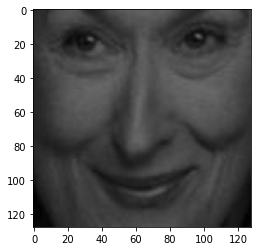

In [7]:
image = cv2.cvtColor(cv2.imread(filename="data/smile.jpg"), code=cv2.COLOR_BGR2RGB)

input_image = cv2.resize(src=image, dsize=(224,224))

# reshape to model input shape
input_image = np.expand_dims(input_image.transpose(2, 0, 1), 0)
plt.imshow(image);


In [8]:
result_infer = compiled_model(inputs=[input_image])[output_layer]
result_index = np.argmax(result_infer)
print(idx_to_class[result_index])

Happy


## Evaluation of accuracy with EfficientNet-B0 FP32

In [11]:
ie = Core()
# path to xml file with model converted to OpenVino's IR format. bin file should be in the same directory
model = ie.read_model(model=os.path.normpath(r"models\enet_b0_8\FP32\enet_b0_8.xml"))
# adding extra output layer
model.add_outputs(['652'])
feature_extractor = ie.compile_model(model=model, device_name="CPU")
input_layer = next(iter(feature_extractor.inputs))
output_layer = feature_extractor.outputs[1]
print(input_layer)
print(output_layer)

<ConstOutput: names[x.1] shape{1,3,224,224} type: f32>
<ConstOutput: names[652] shape{1,1280} type: f32>


Path to faces directory extracted by MTCNN in AFEW Preprocessing.ipynb

In [7]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces'

In [17]:
def test_transforms(filepath):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    face_img = cv2.cvtColor(cv2.imread(filename=filepath), code=cv2.COLOR_BGR2RGB)
    image = cv2.resize(np.float32(face_img), (224, 224))
    image = ((image / 255.0) - mean ) / std
    image = np.expand_dims(image, axis=0)
    image = np.transpose(image, [0, 3, 1, 2]) 

    return image

Path to directory is organised like DATA_DIR/Val_AFEW/emotion_name/video_name/[images from MTCNN]

In [ ]:
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}


def get_features(data_dir):
    filename2features={}
    for class_name in os.listdir(data_dir):
        if class_name in emotion_to_index:
            class_dir = os.path.join(data_dir, class_name)
            # print(class_name)
        for video_name in tqdm(os.listdir(class_dir)):
            video_scores=[]
            frames_dir=os.path.join(class_dir,video_name)
            X_isface=[]
            for img_name in os.listdir(frames_dir):
                filepath=os.path.join(frames_dir,img_name)
                input_image = test_transforms(filepath)
                X_isface.append('noface' not in img_name)
                    
                if input_image.size:
                    scores = feature_extractor(inputs=[input_image])[output_layer]
                    scores = scores.squeeze()
                    video_scores.append(scores)
            filename2features[video_name]=(video_scores,X_isface)
    return filename2features


filename2features_val=get_features(os.path.join(DATA_DIR, 'Val_AFEW'))
filename2features_train=get_features(os.path.join(DATA_DIR, 'Train_AFEW'))

Save extracted features in pickle

In [23]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_openvino.pickle' 
print(MODEL2EMOTIW_FEATURES)


enet_b0_8_afew_openvino.pickle


In [24]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))


In [25]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            #print(filename)
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    #print(features)
                    cur_features=features[features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [26]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')


In [37]:
clf = svm.LinearSVC(C=3) #0.5 1.1 0.6
#clf = svm.SVC(kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5483028720626631
Complete accuracy: 0.5483028720626631


## Evaluation of accuracy with EfficientNet-B0 FP16

In [54]:
ie = Core()
# path to xml file with model converted to OpenVino's IR format. bin file should be in the same directory
model = ie.read_model(model=os.path.normpath(r"models\enet_b0_8\FP16\enet_b0_8_FP16.xml"))
# adding extra output layer
model.add_outputs(['652'])
feature_extractor = ie.compile_model(model=model, device_name="CPU")
input_layer = next(iter(feature_extractor.inputs))
output_layer = feature_extractor.outputs[1]
print(input_layer)
print(output_layer)


<ConstOutput: names[x.1] shape{1,3,224,224} type: f32>
<ConstOutput: names[652] shape{1,1280} type: f32>


Path to the faces directory extracted by MTCNN in AFEW Preprocessing.ipynb

In [55]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces'


In [56]:
def test_transforms(filepath):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    face_img = cv2.cvtColor(cv2.imread(filename=filepath), code=cv2.COLOR_BGR2RGB)
    image = cv2.resize(np.float32(face_img), (224, 224))
    image = ((image / 255.0) - mean ) / std
    image = np.expand_dims(image, axis=0)
    image = np.transpose(image, [0, 3, 1, 2]) 

    return image

Path to directory is organised like DATA_DIR/Val_AFEW/emotion_name/video_name/[images from MTCNN]

In [ ]:
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}


def get_features(data_dir):
    filename2features={}
    for class_name in os.listdir(data_dir):
        if class_name in emotion_to_index:
            class_dir = os.path.join(data_dir, class_name)
            # print(class_name)
        for video_name in tqdm(os.listdir(class_dir)):
            video_scores=[]
            frames_dir=os.path.join(class_dir,video_name)
            X_isface=[]
            for img_name in os.listdir(frames_dir):
                filepath=os.path.join(frames_dir,img_name)
                input_image = test_transforms(filepath)
                X_isface.append('noface' not in img_name)
                    
                if input_image.size:
                    scores = feature_extractor(inputs=[input_image])[output_layer]
                    scores = scores.squeeze()
                    video_scores.append(scores)
            filename2features[video_name]=(video_scores,X_isface)
    return filename2features


filename2features_val=get_features(os.path.join(DATA_DIR, 'Val_AFEW'))
filename2features_train=get_features(os.path.join(DATA_DIR, 'Train_AFEW'))

Save extracted features in pickle

In [58]:
import pickle
model_name = 'enet_b0_8_FP16'
MODEL2EMOTIW_FEATURES=model_name+'_openvino_afew.pickle' 
print(MODEL2EMOTIW_FEATURES)


enet_b0_8_FP16_openvino_afew.pickle


In [ ]:

with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))


Creating a dataset for the classifier

In [59]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            #print(filename)
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    #print(features)
                    cur_features=features[features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [60]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')


In [61]:
clf = svm.LinearSVC(C=3) #0.5 1.1 0.6
#clf = svm.SVC(kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

    
clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
y_pred = clf.predict(x_test_norm)

print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5483028720626631
Complete accuracy: 0.5483028720626631


## Evaluation of accuracy ONNX

In [3]:
import json
import sys
import os
import time
import numpy as np
import cv2
import onnx
import onnxruntime
from onnx import numpy_helper


In [89]:
model = r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8.onnx"


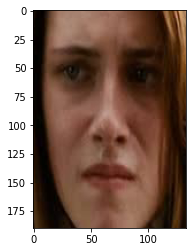

In [6]:
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(filename=r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\data\sad.png"), code=cv2.COLOR_BGR2RGB)

input_image = cv2.resize(src=image, dsize=(224, 224))

# reshape to model input shape
img = np.expand_dims(input_image.transpose(2, 0, 1), 0)
plt.imshow(image)

In [52]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]
)

def torch_transforms(filepath):
    face_img = Image.open(filepath)
    img_tensor = test_transforms(face_img)
    img_arr = img_tensor.numpy()
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr


In [ ]:
def cv_transforms(filepath):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    face_img = cv2.cvtColor(cv2.imread(filename=filepath), code=cv2.COLOR_BGR2RGB)
    image = cv2.resize(face_img, (224, 224))
    image = ((image / 255.0) - mean ) / std
    image = np.expand_dims(image, axis=0)
    image = np.transpose(image, [0, 3, 1, 2]) 
    image = image.astype('float32')

    return image

In [93]:
torch_transforms(r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\data\sad.png')

array([[[[-1.6726604 , -1.6897851 , -1.7069099 , ...,  0.9131775 ,
           1.0673003 ,  1.1700488 ],
         [-1.6726604 , -1.6897851 , -1.7069099 , ...,  0.82755375,
           0.9816765 ,  1.0844251 ],
         [-1.6726604 , -1.6897851 , -1.7069099 , ...,  0.82755375,
           0.93030226,  0.9816765 ],
         ...,
         [-1.3644148 , -1.2616663 , -1.1075436 , ..., -1.7411594 ,
          -1.7069099 , -1.6897851 ],
         [-1.4329139 , -1.3301654 , -1.141793  , ..., -1.7411594 ,
          -1.7069099 , -1.6897851 ],
         [-1.5014129 , -1.3815396 , -1.1760426 , ..., -1.7754089 ,
          -1.7240347 , -1.6897851 ]],

        [[-1.7380952 , -1.7556022 , -1.7731092 , ...,  0.3277312 ,
           0.48529422,  0.57282925],
         [-1.7380952 , -1.7556022 , -1.7731092 , ...,  0.2401962 ,
           0.3977592 ,  0.48529422],
         [-1.7380952 , -1.7556022 , -1.7731092 , ...,  0.2401962 ,
           0.3277312 ,  0.3802522 ],
         ...,
         [-1.6505601 , -1.5455182 

In [94]:
cv_transforms(r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\data\sad.png')

array([[[[-1.6726604 , -1.6897851 , -1.7069099 , ...,  0.9131775 ,
           1.0673003 ,  1.1700488 ],
         [-1.6726604 , -1.6897851 , -1.7069099 , ...,  0.84467846,
           0.9816765 ,  1.0673003 ],
         [-1.6726604 , -1.6897851 , -1.7069099 , ...,  0.82755375,
           0.9131775 ,  0.96455175],
         ...,
         [-1.3644148 , -1.2616663 , -1.1075435 , ..., -1.7411593 ,
          -1.7069099 , -1.6897851 ],
         [-1.4329138 , -1.3301653 , -1.1589177 , ..., -1.7411593 ,
          -1.7240345 , -1.6897851 ],
         [-1.5014127 , -1.3815395 , -1.1760424 , ..., -1.7754089 ,
          -1.7240345 , -1.6897851 ]],

        [[-1.7380953 , -1.7556022 , -1.7731092 , ...,  0.3277311 ,
           0.46778712,  0.5728291 ],
         [-1.7380953 , -1.7556022 , -1.7731092 , ...,  0.2577031 ,
           0.3802521 ,  0.46778712],
         [-1.7380953 , -1.7556022 , -1.7731092 , ...,  0.24019608,
           0.3102241 ,  0.3802521 ],
         ...,
         [-1.6505603 , -1.5455182 

In [90]:
session = onnxruntime.InferenceSession(model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [56]:
data=cv_transforms(r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\data\sad.png")

result = session.run([output_name], {input_name: data})
#print(result)
prediction=int(np.argmax(np.array(result).squeeze(), axis=0))
print(prediction)

6


In [57]:
result # with cv_transforms

[array([[ 2.8346097 , -0.35803843,  2.2342806 ,  2.7858367 , -2.905803  ,
          0.788227  ,  3.5393083 , -1.6595471 ]], dtype=float32)]

In [58]:
data=torch_transforms(r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\data\sad.png")

result = session.run([output_name], {input_name: data})
#print(result)
prediction=int(np.argmax(np.array(result).squeeze(), axis=0))
print(prediction)

6


In [59]:
result #with torch transforms

[array([[ 2.8237362, -0.3799846,  2.222207 ,  2.792626 , -2.9115663,
          0.7795946,  3.5622048, -1.6701827]], dtype=float32)]

In [71]:
import onnx
from onnx import helper

model_path=r'models\enet_b0_8\enet_b0_8.onnx'
model = onnx.load(model_path)
intermediate_layer_value_info = helper.ValueInfoProto()
print(intermediate_layer_value_info)
#intermediate_layer_value_info.name = intermediate_tensor_name
model.graph.output.append(intermediate_layer_value_info)
#onnx.save(model, model_path)

In [ ]:
PATH = r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8.pt'

feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

dummy_input = torch.randn(1, 3, 224, 224).cuda() # Create dummy input for the model. It will be used to run the model inside export function.

torch.onnx.export(feature_extractor_model, (dummy_input, ), 'models/enet_no_cl.onnx') # call the export function

In [60]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces'


In [75]:
model = r'models\enet_no_cl.onnx'

session = onnxruntime.InferenceSession(model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


In [77]:
data=cv_transforms(r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\data\sad.png")

result = session.run([output_name], {input_name: data})
#print(result)
prediction=int(np.argmax(np.array(result).squeeze(), axis=0))
print(prediction)

797


In [79]:
result[0]

array([[-0.08995445, -0.1757714 , -0.01089631, ...,  0.05566255,
        -0.08552808,  0.08019225]], dtype=float32)

In [80]:
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}


def get_features(data_dir):
    filename2features={}
    for class_name in os.listdir(data_dir):
        if class_name in emotion_to_index:
            class_dir = os.path.join(data_dir, class_name)
            # print(class_name)
        for video_name in tqdm(os.listdir(class_dir)):
            video_scores=[]
            frames_dir=os.path.join(class_dir,video_name)
            X_isface=[]
            for img_name in os.listdir(frames_dir):
                filepath=os.path.join(frames_dir,img_name)
                input_image = cv_transforms(filepath)
                X_isface.append('noface' not in img_name)
                    
                if input_image.size:
                    scores = session.run([output_name], {input_name: input_image})
                    scores = scores[0].squeeze()
                    video_scores.append(scores)
            filename2features[video_name]=(video_scores,X_isface)
    return filename2features


filename2features_val=get_features(os.path.join(DATA_DIR, 'Val_AFEW'))
filename2features_train=get_features(os.path.join(DATA_DIR, 'Train_AFEW'))

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

In [81]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_onnx.pickle' 

print(MODEL2EMOTIW_FEATURES)


enet_b0_8_afew_onnx.pickle


In [82]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

In [83]:
print(len(filename2features_train),len(filename2features_val))

773 383


In [84]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            #print(filename)
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    #print(features)
                    cur_features=features[features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [85]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')


In [88]:

clf = svm.LinearSVC(C=3) #0.5 1.1 0.6
#clf = svm.SVC(kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

    
clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
y_pred = clf.predict(x_test_norm)

print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5456919060052219
Complete accuracy: 0.5456919060052219
